In [1]:
# Dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from prophet import Prophet
import datetime as dt

In [2]:
# Load data
a_path = Path("Resources/world_population_data.csv")
b_path = Path("Resources/Production_Crops_Livestock_E_All_Data.csv")
c_path = Path("Resources/API_SP.POP.TOTL_DS2_en_csv_v2_3401680.csv")
d_path = Path("Resources/Lists_test.csv")
world_population = pd.read_csv(a_path)
agri_data = pd.read_csv(b_path, encoding='ISO-8859-1', low_memory = False)
world_population_all_years = pd.read_csv(c_path)
category_ag_data = pd.read_csv(d_path)

In [3]:
# Import Widgets to have dropdown menus
import ipywidgets as widgets 
from IPython.display import display

In [4]:
# Options for dropdown menu
options = ['Asia', 'Europe', 'Africa', 'North America', 'South America',
       'Oceania']

In [5]:
# Dropdown menu
dropdown = widgets.Dropdown(options=options, value=options[0], description='Select')

In [6]:
# Display dropdown menu
display(dropdown)

Dropdown(description='Select', options=('Asia', 'Europe', 'Africa', 'North America', 'South America', 'Oceania…

In [7]:
# View Agricultural data
agri_data.info()
agri_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79606 entries, 0 to 79605
Columns: 195 entries, Area Code to Y2022N
dtypes: float64(62), int64(3), object(130)
memory usage: 118.4+ MB


,Area Code,Area Code (M49),Area,Item Code,Item Code (CPC),Item,Element Code,Element,Unit,Y1961,...,Y2019N,Y2020,Y2020F,Y2020N,Y2021,Y2021F,Y2021N,Y2022,Y2022F,Y2022N
0,2,'004,Afghanistan,221,'01371,"Almonds, in shell",5312,Area harvested,ha,0.0,...,NaN,22134.0,A,NaN,36862.0,A,NaN,37000.0,A,NaN
1,2,'004,Afghanistan,221,'01371,"Almonds, in shell",5419,Yield,100 g/ha,NaN,...,NaN,17759.0,A,NaN,17432.0,A,NaN,17297.0,A,NaN
2,2,'004,Afghanistan,221,'01371,"Almonds, in shell",5510,Production,t,0.0,...,NaN,39307.0,A,NaN,64256.0,A,NaN,64000.0,A,NaN
3,2,'004,Afghanistan,711,'01654,"Anise, badian, coriander, cumin, caraway, fenn...",5312,Area harvested,ha,0.0,...,NaN,25558.0,E,NaN,25357.0,E,NaN,25403.0,E,NaN
4,2,'004,Afghanistan,711,'01654,"Anise, badian, coriander, cumin, caraway, fenn...",5419,Yield,100 g/ha,NaN,...,NaN,7030.0,E,NaN,7050.0,E,NaN,7040.0,E,NaN


In [8]:
# View uniqe values in items, use this data to create csv with categories for group mapping
agri_data["Item"].unique()

array(['Almonds, in shell',
       'Anise, badian, coriander, cumin, caraway, fennel and juniper berries, raw',
       'Apples', 'Apricots', 'Asses', 'Barley',
       'Butter and ghee of sheep milk', 'Butter of cow milk',
       'Buttermilk, dry', 'Camels', 'Cantaloupes and other melons',
       'Cattle', 'Cattle fat, unrendered',
       'Cheese from milk of goats, fresh or processed',
       'Cheese from milk of sheep, fresh or processed', 'Chickens',
       'Cotton lint, ginned', 'Cotton seed', 'Cottonseed oil',
       'Edible offal of cattle, fresh, chilled or frozen',
       'Edible offal of goat, fresh, chilled or frozen',
       'Edible offal of sheep, fresh, chilled or frozen',
       'Edible offals of camels and other camelids, fresh, chilled or frozen',
       'Fat of camels', 'Figs', 'Game meat, fresh, chilled or frozen',
       'Goat fat, unrendered', 'Goats', 'Grapes',
       'Hen eggs in shell, fresh', 'Horses', 'Linseed', 'Maize (corn)',
       'Meat of camels, fresh or c

In [9]:
# View Columns to determine which columns to keep or drop
print(agri_data.columns)

Index(['Area Code', 'Area Code (M49)', 'Area', 'Item Code', 'Item Code (CPC)',
       'Item', 'Element Code', 'Element', 'Unit', 'Y1961',
       ...
       'Y2019N', 'Y2020', 'Y2020F', 'Y2020N', 'Y2021', 'Y2021F', 'Y2021N',
       'Y2022', 'Y2022F', 'Y2022N'],
      dtype='object', length=195)


In [10]:
#Drop columns that are not needed
columns_to_drop =["Area Code", "Area Code (M49)", "Item Code", "Item Code (CPC)", "Element Code", "Element"]
agri_data.drop(columns=columns_to_drop, inplace=True)

# Rename Area to Country
agri_data = agri_data.rename(columns={"Area": "Country"})

#Remove Y from year
agri_data.columns = agri_data.columns.str.replace("Y", "")

# Display df
agri_data.head()

,Country,Item,Unit,1961,1961F,1961N,1962,1962F,1962N,1963,...,2019N,2020,2020F,2020N,2021,2021F,2021N,2022,2022F,2022N
0,Afghanistan,"Almonds, in shell",ha,0.0,A,NaN,0.0,A,NaN,0.0,...,NaN,22134.0,A,NaN,36862.0,A,NaN,37000.0,A,NaN
1,Afghanistan,"Almonds, in shell",100 g/ha,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,17759.0,A,NaN,17432.0,A,NaN,17297.0,A,NaN
2,Afghanistan,"Almonds, in shell",t,0.0,A,NaN,0.0,A,NaN,0.0,...,NaN,39307.0,A,NaN,64256.0,A,NaN,64000.0,A,NaN
3,Afghanistan,"Anise, badian, coriander, cumin, caraway, fenn...",ha,0.0,M,NaN,0.0,M,NaN,0.0,...,NaN,25558.0,E,NaN,25357.0,E,NaN,25403.0,E,NaN
4,Afghanistan,"Anise, badian, coriander, cumin, caraway, fenn...",100 g/ha,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,7030.0,E,NaN,7050.0,E,NaN,7040.0,E,NaN


In [11]:
# remove columns that do not hold numerical example 1962F and 1962N 
columns_to_drop2 = [col for col in agri_data.columns if col.endswith('F') or col.endswith('N')]
df_cleaned = agri_data.drop(columns=columns_to_drop2)
df_cleaned.head()

,Country,Item,Unit,1961,1962,1963,1964,1965,1966,1967,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Afghanistan,"Almonds, in shell",ha,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,14114.0,13703.0,14676.0,19481.0,19793.0,20053.0,29203.0,22134.0,36862.0,37000.0
1,Afghanistan,"Almonds, in shell",100 g/ha,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,29910.0,19996.0,16521.0,16859.0,13788.0,17161.0,13083.0,17759.0,17432.0,17297.0
2,Afghanistan,"Almonds, in shell",t,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,42215.0,27400.0,24246.0,32843.0,27291.0,34413.0,38205.0,39307.0,64256.0,64000.0
3,Afghanistan,"Anise, badian, coriander, cumin, caraway, fenn...",ha,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,18500.0,30000.0,25000.0,24500.0,26160.0,25220.0,25293.0,25558.0,25357.0,25403.0
4,Afghanistan,"Anise, badian, coriander, cumin, caraway, fenn...",100 g/ha,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6757.0,7167.0,7200.0,7075.0,6970.0,7080.0,7041.0,7030.0,7050.0,7040.0


In [12]:
#Display category data for Ag dataset
category_ag_data.info()
category_ag_data.head()
category_ag_data['Category'].unique()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Item      158 non-null    object
 1   Category  158 non-null    object
dtypes: object(2)
memory usage: 2.6+ KB


array(['Dairy', 'Eggs', 'Fruit', 'Grain', 'Honey', 'Meat', 'Nut', 'Sugar',
       'Vegetable'], dtype=object)

In [13]:
# Make category_ag_data.set a dictionary and set index
group_mapping = category_ag_data.set_index('Item')['Category'].to_dict()

In [14]:
# Create a new column named 'Category' in df based on 'Item' defined in group_mapping
df_cleaned['Category'] = df_cleaned['Item'].replace(group_mapping)
df_cleaned.head()

,Country,Item,Unit,1961,1962,1963,1964,1965,1966,1967,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,Category
0,Afghanistan,"Almonds, in shell",ha,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13703.0,14676.0,19481.0,19793.0,20053.0,29203.0,22134.0,36862.0,37000.0,Nut
1,Afghanistan,"Almonds, in shell",100 g/ha,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,19996.0,16521.0,16859.0,13788.0,17161.0,13083.0,17759.0,17432.0,17297.0,Nut
2,Afghanistan,"Almonds, in shell",t,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,27400.0,24246.0,32843.0,27291.0,34413.0,38205.0,39307.0,64256.0,64000.0,Nut
3,Afghanistan,"Anise, badian, coriander, cumin, caraway, fenn...",ha,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,30000.0,25000.0,24500.0,26160.0,25220.0,25293.0,25558.0,25357.0,25403.0,"Anise, badian, coriander, cumin, caraway, fenn..."
4,Afghanistan,"Anise, badian, coriander, cumin, caraway, fenn...",100 g/ha,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7167.0,7200.0,7075.0,6970.0,7080.0,7041.0,7030.0,7050.0,7040.0,"Anise, badian, coriander, cumin, caraway, fenn..."


In [15]:
# Filter Units column for Tonnes, Animals or 1000 Animals
filtered_df = df_cleaned[df_cleaned['Unit'].isin(['t', 'An', '1000 An'])]

# Filter out items that do have assigned categories
categories_to_keep = ['Dairy', 'Eggs', 'Fruit', 'Grain', 'Honey', 'Meat', 'Nut', 'Sugar', 'Vegetable']
filtered_df = filtered_df[filtered_df['Category'].isin(categories_to_keep)]

#Re-order Dataframe
columns = filtered_df.columns.tolist()
category_index = columns.index('Category')
columns.insert(2, columns.pop(category_index))
ag_df = filtered_df[columns]
ag_df.head(10)

#Display DF
ag_df.head(10)

,Country,Item,Category,Unit,1961,1962,1963,1964,1965,1966,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
2,Afghanistan,"Almonds, in shell",Nut,t,0.0,0.00,0.0,0.0,0.00,0.00,...,42215.00,27400.00,24246.00,32843.00,27291.00,34413.00,38205.00,39307.00,64256.00,64000.00
8,Afghanistan,Apples,Fruit,t,15100.0,15100.00,15100.0,18400.0,20400.00,22800.00,...,78597.00,89403.00,89733.00,140903.00,170443.00,217192.00,250324.00,270857.00,321672.00,318000.00
11,Afghanistan,Apricots,Fruit,t,32000.0,32000.00,32000.0,39200.0,43400.00,48400.00,...,90000.00,90000.00,87686.00,17894.00,131816.00,109086.00,129363.00,131788.00,207490.00,170507.92
12,Afghanistan,Asses,Meat,An,1300000.0,851850.00,1001112.0,1150000.0,1300000.00,1200000.00,...,1451000.00,1441000.00,1481000.00,1472100.00,1317000.00,1329850.00,1552264.00,1534307.00,1552976.00,1571646.00
15,Afghanistan,Barley,Grain,t,378000.0,378000.00,378000.0,380000.0,380000.00,375000.00,...,514000.00,521000.00,403000.00,301856.00,94995.00,56781.00,123576.00,127757.00,65102.00,110000.00
16,Afghanistan,Butter and ghee of sheep milk,Dairy,t,4104.0,4124.25,4414.5,4725.0,4880.25,4421.25,...,4927.50,4557.01,4495.76,4508.70,4651.73,4679.01,3803.54,4604.94,4588.54,NaN
17,Afghanistan,Butter of cow milk,Dairy,t,7000.0,7000.00,8000.0,8000.0,9000.00,10000.00,...,30795.34,42723.93,37869.02,37987.38,36450.12,37098.96,36731.28,36357.00,36798.21,NaN
18,Afghanistan,"Buttermilk, dry",Dairy,t,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,7002.20,6057.24,6440.46,5827.45,5931.40,5895.51,5829.46,5884.56,NaN
19,Afghanistan,Camels,Meat,An,250000.0,279910.00,349405.0,325000.0,300000.00,300000.00,...,170000.00,171000.00,170000.00,170500.00,172000.00,171384.00,168923.00,168240.00,167234.00,166227.00
22,Afghanistan,Cantaloupes and other melons,Fruit,t,15700.0,15700.00,16600.0,17500.0,18000.00,18500.00,...,180070.00,274250.00,302067.00,506266.00,493087.66,389472.93,464230.00,793496.00,801514.01,809194.26


In [16]:
# Convert 1000 An to An so that all animals can be combined using same values
# Identify rows with '1000 An' in the 'Unit' column
multiply_by = ag_df['Unit'] == '1000 An'

# Multiply the values by 1000 where 'Unit' is '1000 An'
ag_df.loc[multiply_by, ag_df.columns[4:]] = ag_df.loc[multiply_by, ag_df.columns[4:]].multiply(1000)

# Use .loc to replace '1000 An' with 'An' in the 'Unit' column
ag_df.loc[ag_df['Unit'] == '1000 An', 'Unit'] = 'An'

# Display DF
ag_df.head()

,Country,Item,Category,Unit,1961,1962,1963,1964,1965,1966,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
2,Afghanistan,"Almonds, in shell",Nut,t,0.0,0.0,0.0,0.0,0.0,0.0,...,42215.0,27400.0,24246.0,32843.0,27291.0,34413.0,38205.0,39307.0,64256.0,64000.00
8,Afghanistan,Apples,Fruit,t,15100.0,15100.0,15100.0,18400.0,20400.0,22800.0,...,78597.0,89403.0,89733.0,140903.0,170443.0,217192.0,250324.0,270857.0,321672.0,318000.00
11,Afghanistan,Apricots,Fruit,t,32000.0,32000.0,32000.0,39200.0,43400.0,48400.0,...,90000.0,90000.0,87686.0,17894.0,131816.0,109086.0,129363.0,131788.0,207490.0,170507.92
12,Afghanistan,Asses,Meat,An,1300000.0,851850.0,1001112.0,1150000.0,1300000.0,1200000.0,...,1451000.0,1441000.0,1481000.0,1472100.0,1317000.0,1329850.0,1552264.0,1534307.0,1552976.0,1571646.00
15,Afghanistan,Barley,Grain,t,378000.0,378000.0,378000.0,380000.0,380000.0,375000.0,...,514000.0,521000.0,403000.0,301856.0,94995.0,56781.0,123576.0,127757.0,65102.0,110000.00


In [17]:
#Add 'Continent' column to ag_df, by merging world_popultion dataset
columns_to_drop2 =["2023 population", "cca3", "2022 population", "2020 population", "2015 population", "2010 population", "2000 population", "1990 population", "1980 population", "1970 population"]
world_population.drop(columns=columns_to_drop2, inplace=True)
world_population.rename(columns={"country": "Country", "continent": "Continent"}, inplace=True)

# Create new df, for this merge and keep world_population for later use below
wp_for_merge = world_population.copy()
columns_to_drop3 =["rank", "area (km²)", "density (km²)", "growth rate", "world percentage"]
wp_for_merge.drop(columns=columns_to_drop3, inplace=True)

# Merge Dataset using inner 
ag_df_fnl = pd.merge(ag_df, wp_for_merge, on= "Country", how="inner")

#Re-order Dataframe
columns = ag_df_fnl.columns.tolist()
category_index = columns.index('Continent')
columns.insert(1, columns.pop(category_index))
ag_df_fnl = ag_df_fnl[columns]

# Display DF
ag_df_fnl.head()

,Country,Continent,Item,Category,Unit,1961,1962,1963,1964,1965,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Afghanistan,Asia,"Almonds, in shell",Nut,t,0.0,0.0,0.0,0.0,0.0,...,42215.0,27400.0,24246.0,32843.0,27291.0,34413.0,38205.0,39307.0,64256.0,64000.00
1,Afghanistan,Asia,Apples,Fruit,t,15100.0,15100.0,15100.0,18400.0,20400.0,...,78597.0,89403.0,89733.0,140903.0,170443.0,217192.0,250324.0,270857.0,321672.0,318000.00
2,Afghanistan,Asia,Apricots,Fruit,t,32000.0,32000.0,32000.0,39200.0,43400.0,...,90000.0,90000.0,87686.0,17894.0,131816.0,109086.0,129363.0,131788.0,207490.0,170507.92
3,Afghanistan,Asia,Asses,Meat,An,1300000.0,851850.0,1001112.0,1150000.0,1300000.0,...,1451000.0,1441000.0,1481000.0,1472100.0,1317000.0,1329850.0,1552264.0,1534307.0,1552976.0,1571646.00
4,Afghanistan,Asia,Barley,Grain,t,378000.0,378000.0,378000.0,380000.0,380000.0,...,514000.0,521000.0,403000.0,301856.0,94995.0,56781.0,123576.0,127757.0,65102.0,110000.00


In [18]:
ag_df_fnl.to_csv("ag_df_fnl.csv", index=False)

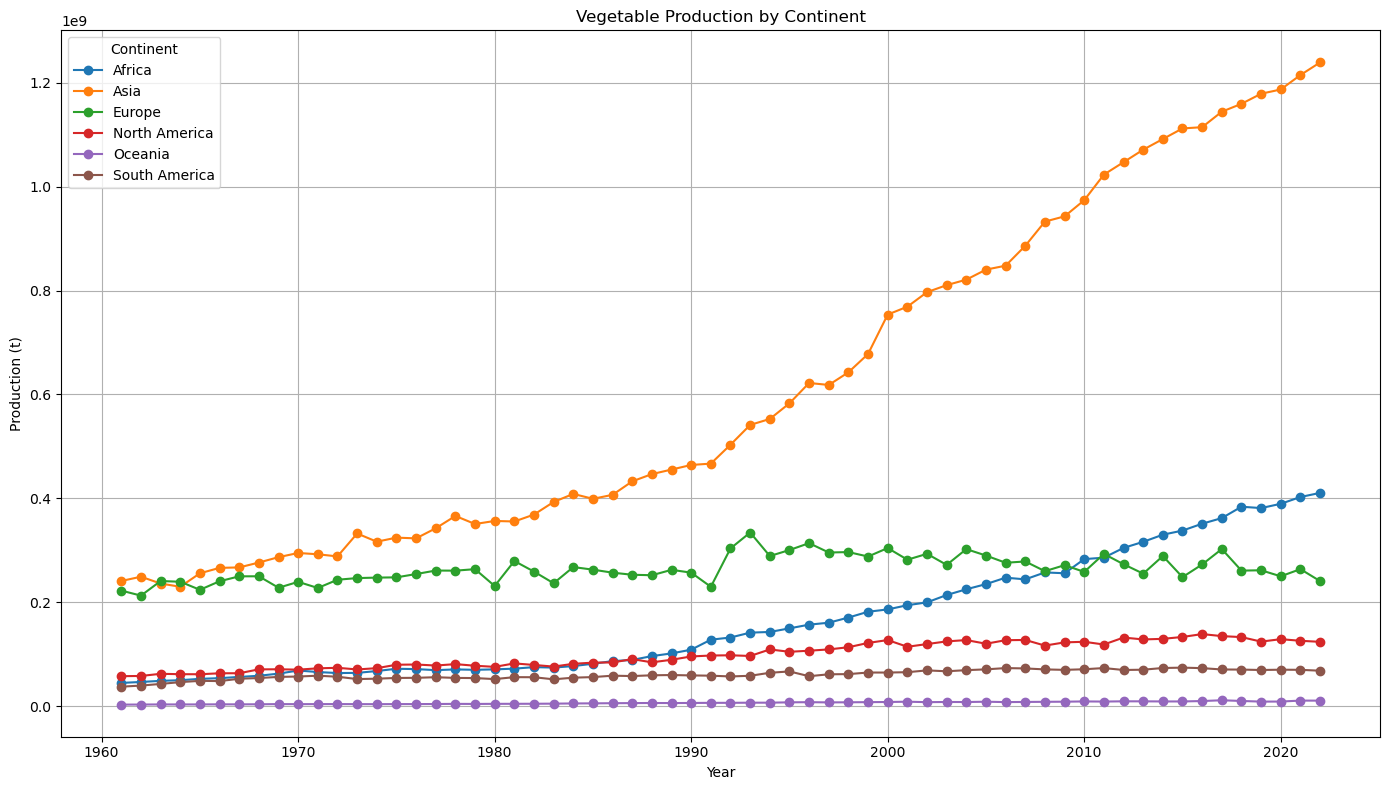

In [35]:
# Plot Category by Continent for selected category
# Filter data for the required category and unit
category = 'Vegetable'  #Change this to plot different categories (Great use case for dropdown)

# Create an if statement to auto select units based on what category is selected
if category == 'Meat':
    unit = 'An' # Unit of measurement 'An' for single animal
else:
    unit = 't' # Unit of measurement 't' for tonnes

# Filter the dataset for the selected category and unit
category_df = ag_df_fnl[(ag_df_fnl['Category'] == category) & (ag_df_fnl['Unit'] == unit)]

# Group by Continent and Year and sum the production values
grouped_df = category_df.groupby(['Continent']).sum(numeric_only=True).reset_index()

# Melt the DataFrame to make it easier for plotting
melted_df = pd.melt(grouped_df, id_vars=['Continent'], 
                    value_vars=[str(year) for year in range(1961, 2023)],
                    var_name='Year', value_name='Value')

# Convert Year to datetime format for proper plotting
melted_df['Year'] = pd.to_datetime(melted_df['Year'], format='%Y')

#Plot all continents on the same graph
plt.figure(figsize=(14, 8))

# Loop through each continent and plot its data
for continent in melted_df['Continent'].unique():
    data = melted_df[melted_df['Continent'] == continent]
    plt.plot(data['Year'], data['Value'], marker='o', label=continent) # Add label = Continent 

# Adding labels and title
plt.xlabel('Year')
plt.ylabel(f'Production ({unit})')
plt.title(f'{category} Production by Continent')
plt.grid(True)

# Display legend
plt.legend(title='Continent')

# Show the plot
plt.tight_layout()
plt.show()

In [20]:
ag_df_fnl['Country'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Bulgaria',
       'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Comoros', 'Cook Islands', 'Costa Rica', 'Croatia', 'Cuba',
       'Cyprus', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic',
       'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea',
       'Estonia', 'Eswatini', 'Ethiopia', 'Faroe Islands', 'Fiji',
       'Finland', 'France', 'French Guiana', 'French Polynesia', 'Gabon',
       'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada',
       'Guadeloupe', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana',
       'Haiti', 'Honduras', 'Hungary'

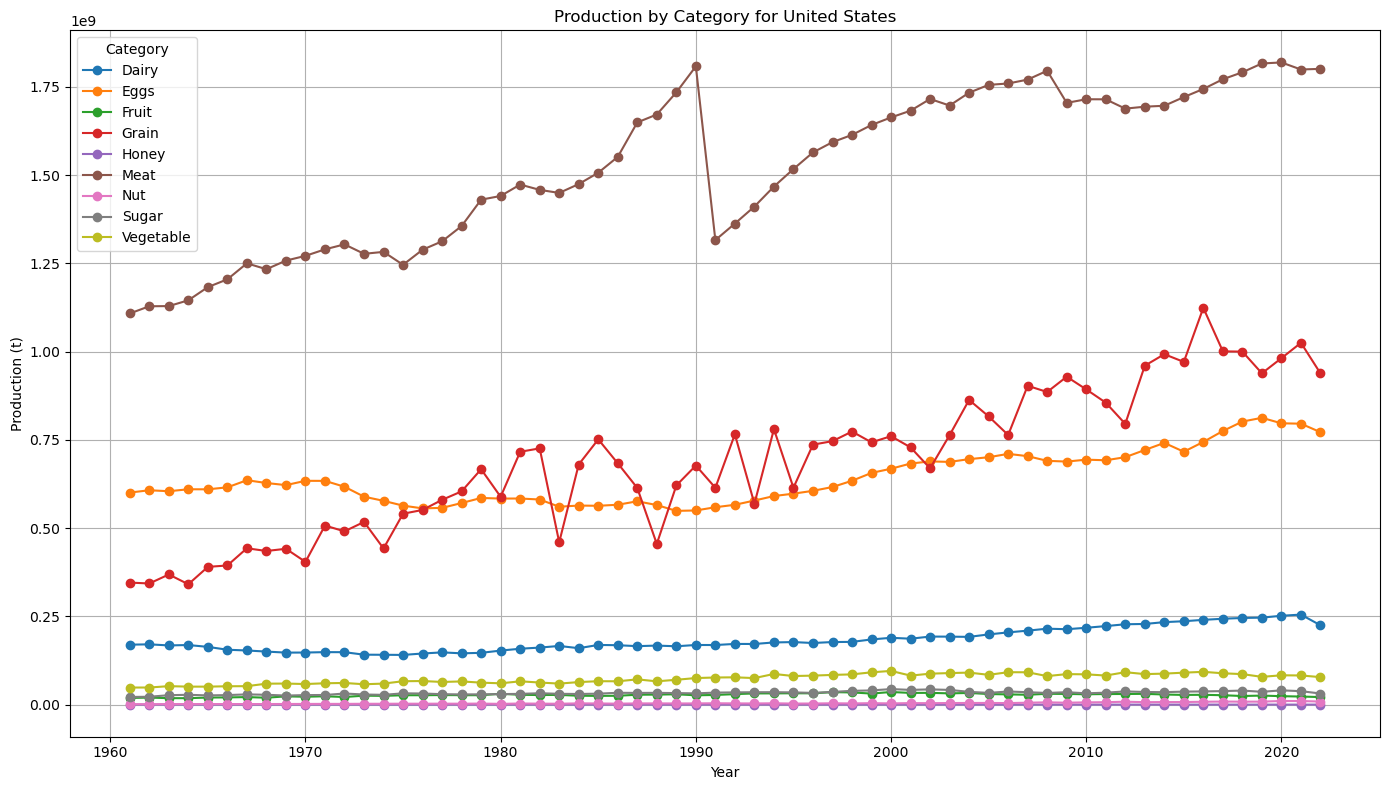

In [49]:
# Let User Select a Country , and display categories

# Filter the data for Selected Counrty
selected_country = 'United States' # This would be another good place for a drop down

# Filter the dataset for the selected category and unit
country_df = ag_df_fnl[(ag_df_fnl['Country'] == selected_country)]

# Group by Country, Category, and Year and sum the production values
grouped_df = country_df.groupby(['Country', 'Category']).sum(numeric_only=True).reset_index()

# Melt the DataFrame to make it easier for plotting
melted_df = pd.melt(grouped_df, id_vars=['Country', 'Category'], 
                    value_vars=[str(year) for year in range(1961, 2023)],
                    var_name='Year', value_name='Value')

# Convert Year to datetime format for proper plotting
melted_df['Year'] = pd.to_datetime(melted_df['Year'], format='%Y')

# Plot each category as a separate line
plt.figure(figsize=(14, 8))

# Loop through each category and plot its data
for category in melted_df['Category'].unique():
    data = melted_df[melted_df['Category'] == category]
    plt.plot(data['Year'], data['Value'], marker='o', label=category)  # Add label = category

# Adding labels and title
plt.xlabel('Year')
plt.ylabel(f'Production ({unit})')
plt.title(f'Production by Category for {selected_country}')
plt.grid(True)

# Display legend
plt.legend(title='Category')

# Show the plot
plt.tight_layout()
plt.show()

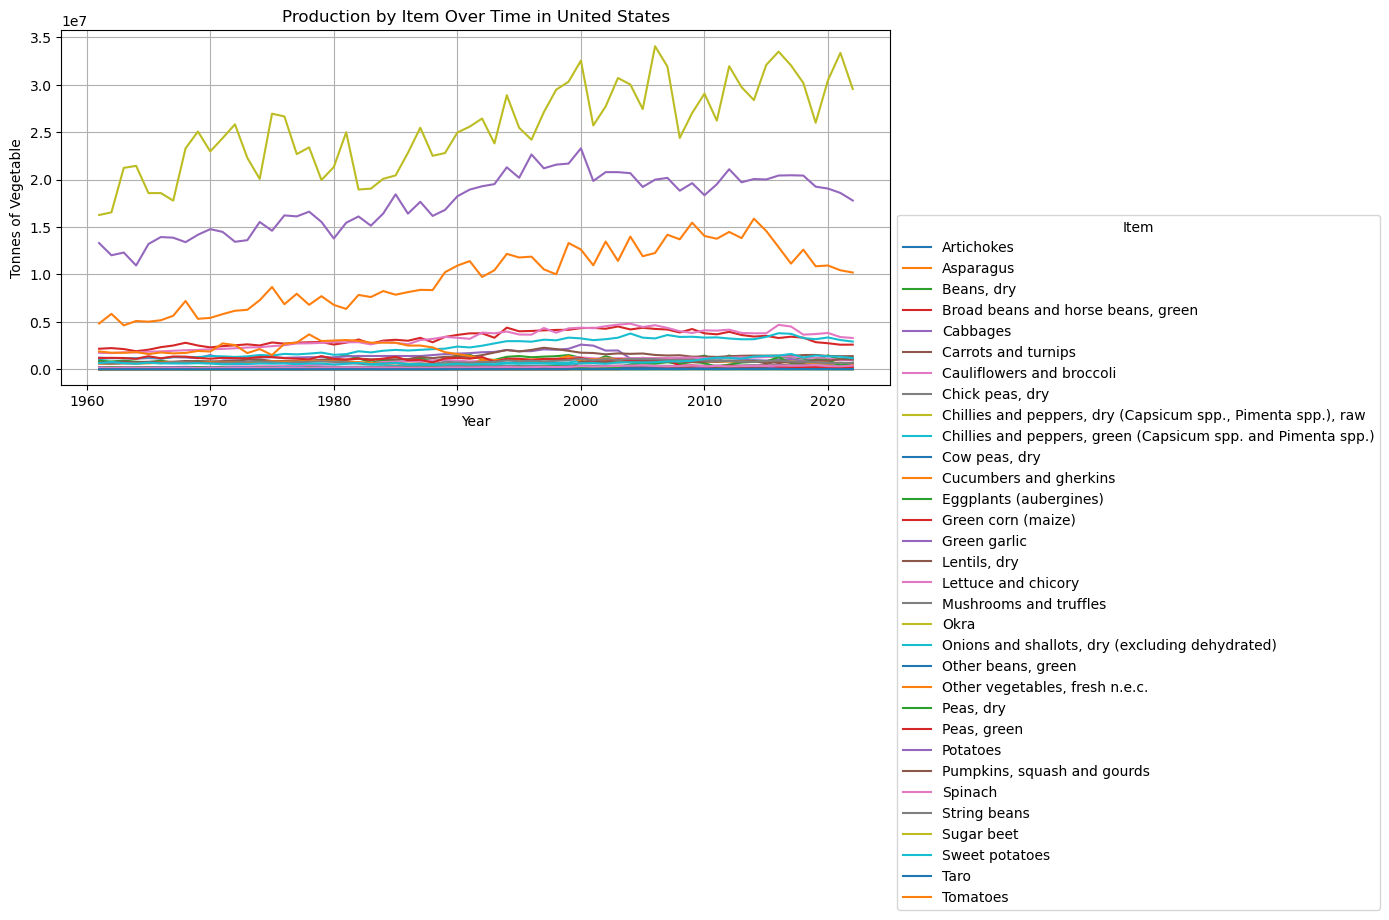

In [69]:
# Let User Select a Category, display Items vs time in graph


# Filter the data for the Category

selected_category = 'Vegetable'

# Check the selected category and set the unit accordingly
if selected_category == 'Meat':
    selected_unit = 'An'
else:
    selected_unit = 't'

# Filter the dataset for the selected country, category, and unit
country_category_df = ag_df_fnl[
    (ag_df_fnl['Country'] == selected_country) &
    (ag_df_fnl['Category'] == selected_category) &
    (ag_df_fnl['Unit'] == selected_unit)  
]

# Group by Item and Year and sum the production values
grouped_item_df = country_category_df.groupby(['Item']).sum(numeric_only=True).reset_index()

# Melt the DataFrame to make it easier for plotting
melted_item_df = pd.melt(
    grouped_item_df, 
    id_vars=['Item'], 
    value_vars=[str(year) for year in range(1961, 2023)], 
    var_name='Year', 
    value_name='Production'
)

# Convert Year to datetime format for proper plotting
melted_item_df['Year'] = pd.to_datetime(melted_item_df['Year'], format='%Y')

# Plot all items in the selected category on the same graph
plt.figure(figsize=(14, 8))

# Loop through each item and plot the data
for item in melted_item_df['Item'].unique():
    data = melted_item_df[melted_item_df['Item'] == item]
    plt.plot(data['Year'], data['Production'], label=item)

# Adding labels and title
if selected_category == 'Meat':
    y_label = f'Qantity of Animals'
else:
    y_label = f'Tonnes of {selected_category}'
    
plt.xlabel('Year')
plt.ylabel(y_label)
plt.title(f'Production by Item Over Time in {selected_country}')
plt.grid(True)

# Display legend and move it from displaying over graph
plt.legend(title='Item', loc='upper left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.tight_layout()
plt.show()

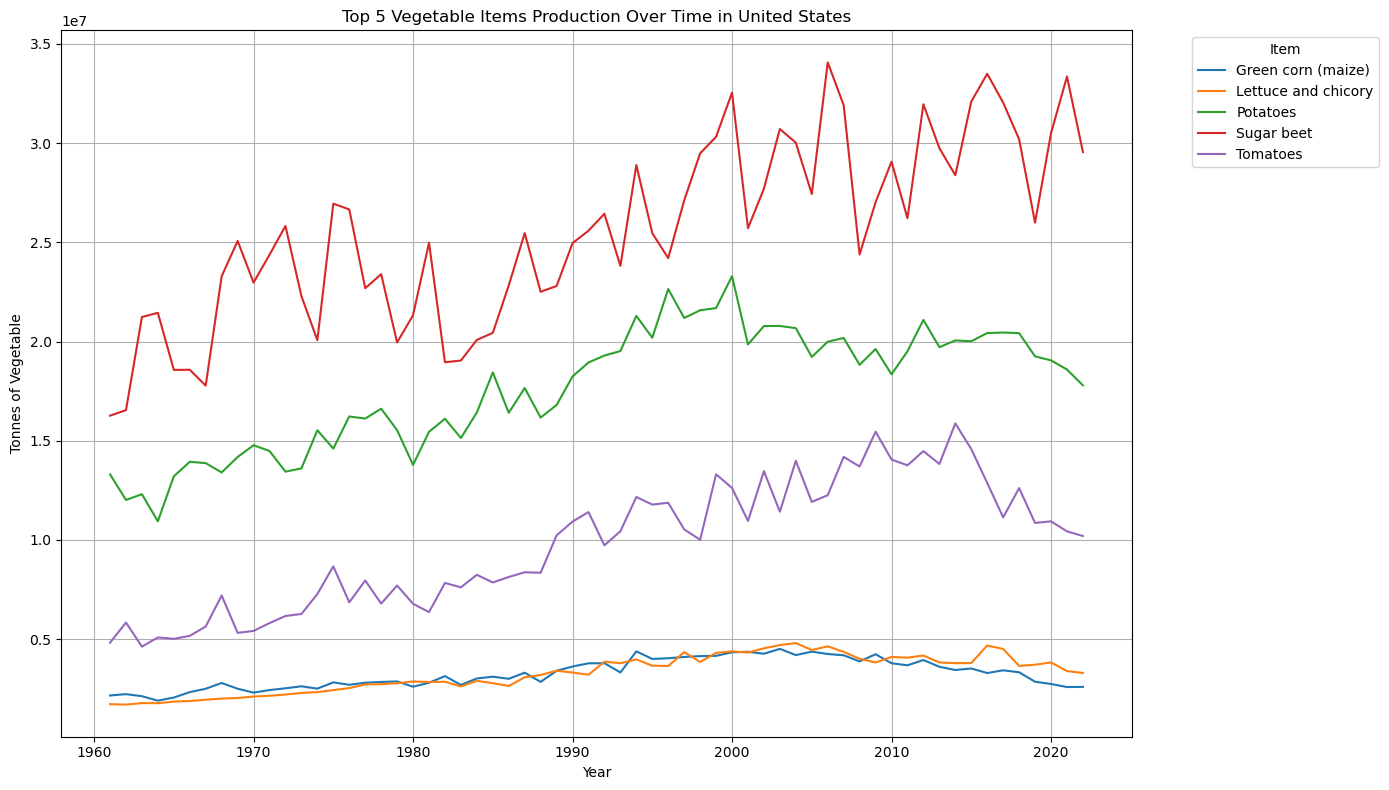

In [67]:
# Filter the data for top 5 of selected 'Category' for selected 'Country'

# Calculate the total production for each item and select the top 5 items
grouped_item_df['Total_Production'] = grouped_item_df[
    [str(year) for year in range(1961, 2023)]
].sum(axis=1)

# Get the top 5 items based on total production
top_items = grouped_item_df.nlargest(5, 'Total_Production')['Item'].tolist()

# Filter the data to include only the top 5 items
grouped_item_df = grouped_item_df[grouped_item_df['Item'].isin(top_items)]

# Melt the DataFrame to make it easier for plotting
melted_item_df = pd.melt(
    grouped_item_df,
    id_vars=['Item'],
    value_vars=[str(year) for year in range(1961, 2023)],
    var_name='Year',
    value_name='Production'
)

# Convert Year to datetime format for proper plotting
melted_item_df['Year'] = pd.to_datetime(melted_item_df['Year'], format='%Y')

# Plot all items in the selected category on the same graph
plt.figure(figsize=(14, 8))

# Loop through each item and plot the data
for item in melted_item_df['Item'].unique():
    data = melted_item_df[melted_item_df['Item'] == item]
    plt.plot(data['Year'], data['Production'], label=item)

# Adding labels and title
if selected_category == 'Meat':
    y_label = f'Quantity of Animals'
else:
    y_label = f'Tonnes of {selected_category}'

plt.xlabel('Year')
plt.ylabel(y_label)
plt.title(f'Top 5 {selected_category} Items Production Over Time in {selected_country}')
plt.grid(True)

# Display legend and move it from displaying over graph
plt.legend(title='Item', loc='upper left', bbox_to_anchor=(1.05, 1))

# Show the plot
plt.tight_layout()
plt.show()


In [24]:
#Display world population datasets and merge them on Country

display(world_population.head())
display(world_population_all_years.head())

,rank,Country,Continent,area (km²),density (km²),growth rate,world percentage
0,1,India,Asia,3287590.0,481,0.81%,17.85%
1,2,China,Asia,9706961.0,151,-0.02%,17.81%
2,3,United States,North America,9372610.0,37,0.50%,4.25%
3,4,Indonesia,Asia,1904569.0,148,0.74%,3.47%
4,5,Pakistan,Asia,881912.0,312,1.98%,3.00%


,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54608.0,55811.0,56682.0,57475.0,58178.0,58782.0,...,103594.0,104257.0,104874.0,105439.0,105962.0,106442.0,106585.0,106537.0,106445.0,106277.0
1,Africa Eastern and Southern,AFE,"Population, total",SP.POP.TOTL,130692579.0,134169237.0,137835590.0,141630546.0,145605995.0,149742351.0,...,583651101.0,600008424.0,616377605.0,632746570.0,649757148.0,667242986.0,685112979.0,702977106.0,720859132.0,739108306.0
2,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8622466.0,8790140.0,8969047.0,9157465.0,9355514.0,9565147.0,...,32716210.0,33753499.0,34636207.0,35643418.0,36686784.0,37769499.0,38972230.0,40099462.0,41128771.0,42239854.0
3,Africa Western and Central,AFW,"Population, total",SP.POP.TOTL,97256290.0,99314028.0,101445032.0,103667517.0,105959979.0,108336203.0,...,397855507.0,408690375.0,419778384.0,431138704.0,442646825.0,454306063.0,466189102.0,478185907.0,490330870.0,502789511.0
4,Angola,AGO,"Population, total",SP.POP.TOTL,5357195.0,5441333.0,5521400.0,5599827.0,5673199.0,5736582.0,...,27128337.0,28127721.0,29154746.0,30208628.0,31273533.0,32353588.0,33428486.0,34503774.0,35588987.0,36684202.0


In [25]:
# Remove 'Indicator Code' column and rename 'Country Name' to 'Country', merge on 'Country' using "inner"
columns_to_drop3 =["Indicator Code"]
world_population_all_years.drop(columns=columns_to_drop3, inplace=True)
world_population_all_years.rename(columns={"Country Name": "Country"}, inplace=True)

# Merge DF's
merged_pop_data = pd.merge(world_population_all_years, world_population, on= "Country", how="inner")

#Display DF
merged_pop_data.head()

,Country,Country Code,Indicator Name,1960,1961,1962,1963,1964,1965,1966,...,2020,2021,2022,2023,rank,Continent,area (km²),density (km²),growth rate,world percentage
0,Aruba,ABW,"Population, total",54608.0,55811.0,56682.0,57475.0,58178.0,58782.0,59291.0,...,106585.0,106537.0,106445.0,106277.0,198,North America,180.0,590,-0.16%,0.00%
1,Afghanistan,AFG,"Population, total",8622466.0,8790140.0,8969047.0,9157465.0,9355514.0,9565147.0,9783147.0,...,38972230.0,40099462.0,41128771.0,42239854.0,36,Asia,652230.0,65,2.70%,0.53%
2,Angola,AGO,"Population, total",5357195.0,5441333.0,5521400.0,5599827.0,5673199.0,5736582.0,5787044.0,...,33428486.0,34503774.0,35588987.0,36684202.0,42,Africa,1246700.0,29,3.08%,0.46%
3,Albania,ALB,"Population, total",1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,1914573.0,...,2837849.0,2811666.0,2777689.0,2745972.0,138,Europe,28748.0,103,-0.35%,0.04%
4,Andorra,AND,"Population, total",9443.0,10216.0,11014.0,11839.0,12690.0,13563.0,14546.0,...,77700.0,79034.0,79824.0,80088.0,203,Europe,468.0,170,0.33%,0.00%


In [26]:
merged_pop_data.to_csv("merged_pop_data.csv", index=False)

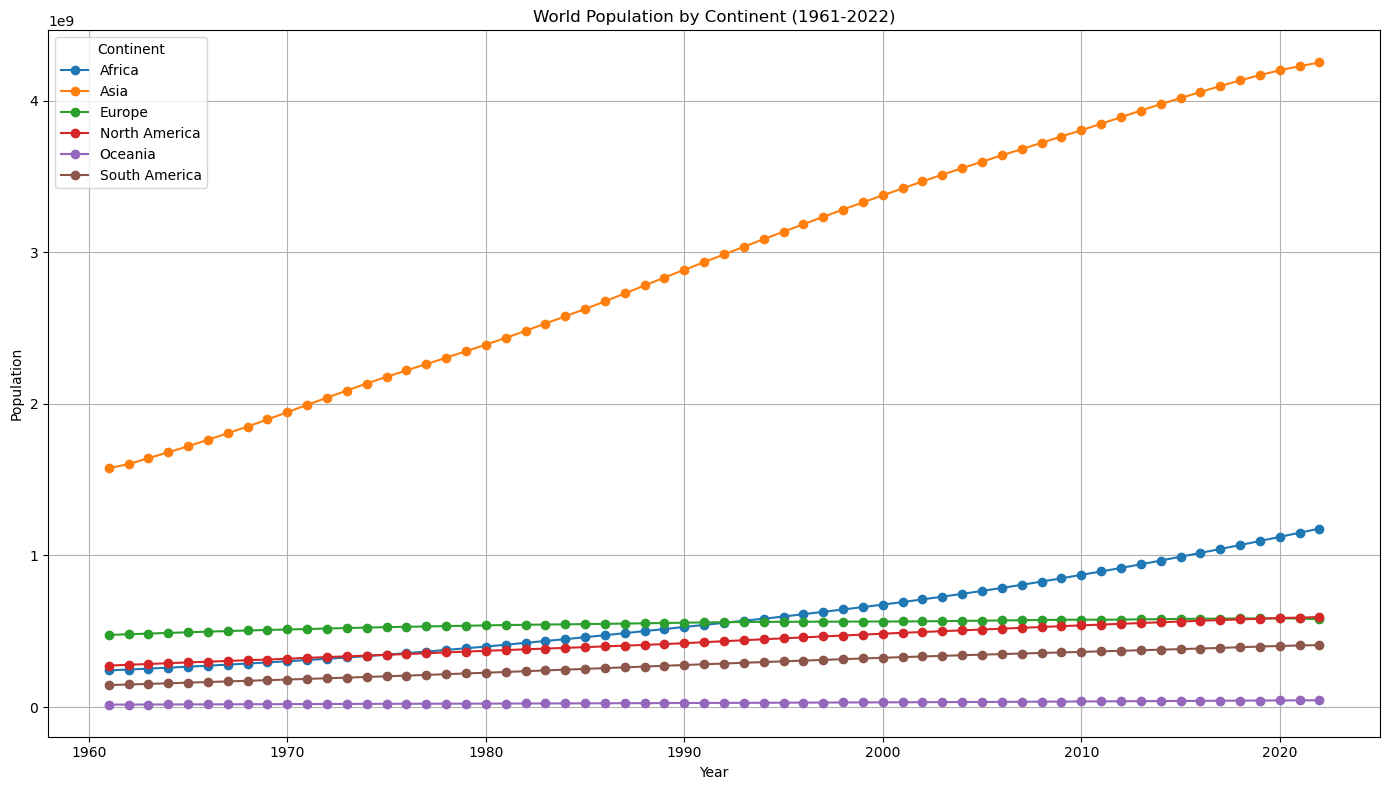

In [27]:
# Graph popultation data by continent over time
# Group by Continent and sum the population values for each year
pop_grouped = merged_pop_data.groupby(['Continent']).sum(numeric_only=True).reset_index()

# Melt the DataFrame to make it easier for plotting
melted_pop_df = pd.melt(pop_grouped, id_vars=['Continent'], 
                        value_vars=[str(year) for year in range(1961, 2023)],
                        var_name='Year', value_name='Population')

# Convert Year to datetime format for proper plotting
melted_pop_df['Year'] = pd.to_datetime(melted_pop_df['Year'], format='%Y')

# Plot all continents on the same graph
plt.figure(figsize=(14, 8))

# Loop through each continent and plot its data
for continent in melted_pop_df['Continent'].unique():
    data = melted_pop_df[melted_pop_df['Continent'] == continent]
    plt.plot(data['Year'], data['Population'], marker='o', label=continent)

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Population')
plt.title('World Population by Continent (1961-2022)')
plt.grid(True)

# Display legend
plt.legend(title='Continent')

# Show the plot
plt.tight_layout()
plt.show()

In [28]:
#Merge Ag and population data
final_merge = pd.merge(ag_df_fnl, merged_pop_data, on= "Country", how="inner")
final_merge.info()
final_merge.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12385 entries, 0 to 12384
Columns: 139 entries, Country to world percentage
dtypes: float64(127), int64(2), object(10)
memory usage: 13.1+ MB


,Country,Continent_x,Item,Category,Unit,1961_x,1962_x,1963_x,1964_x,1965_x,...,2020_y,2021_y,2022_y,2023,rank,Continent_y,area (km²),density (km²),growth rate,world percentage
0,Afghanistan,Asia,"Almonds, in shell",Nut,t,0.0,0.0,0.0,0.0,0.0,...,38972230.0,40099462.0,41128771.0,42239854.0,36,Asia,652230.0,65,2.70%,0.53%
1,Afghanistan,Asia,Apples,Fruit,t,15100.0,15100.0,15100.0,18400.0,20400.0,...,38972230.0,40099462.0,41128771.0,42239854.0,36,Asia,652230.0,65,2.70%,0.53%
2,Afghanistan,Asia,Apricots,Fruit,t,32000.0,32000.0,32000.0,39200.0,43400.0,...,38972230.0,40099462.0,41128771.0,42239854.0,36,Asia,652230.0,65,2.70%,0.53%
3,Afghanistan,Asia,Asses,Meat,An,1300000.0,851850.0,1001112.0,1150000.0,1300000.0,...,38972230.0,40099462.0,41128771.0,42239854.0,36,Asia,652230.0,65,2.70%,0.53%
4,Afghanistan,Asia,Barley,Grain,t,378000.0,378000.0,378000.0,380000.0,380000.0,...,38972230.0,40099462.0,41128771.0,42239854.0,36,Asia,652230.0,65,2.70%,0.53%


In [29]:
# Remove 'Continent_y' column and rename 'Continent_x' to 'Continent'
columns_to_drop4 =["Continent_y"]
final_merge.drop(columns=columns_to_drop4, inplace=True)
final_merge.rename(columns={"Continent_x": "Continent"}, inplace=True)

#Display DF
final_merge.head()

,Country,Continent,Item,Category,Unit,1961_x,1962_x,1963_x,1964_x,1965_x,...,2019_y,2020_y,2021_y,2022_y,2023,rank,area (km²),density (km²),growth rate,world percentage
0,Afghanistan,Asia,"Almonds, in shell",Nut,t,0.0,0.0,0.0,0.0,0.0,...,37769499.0,38972230.0,40099462.0,41128771.0,42239854.0,36,652230.0,65,2.70%,0.53%
1,Afghanistan,Asia,Apples,Fruit,t,15100.0,15100.0,15100.0,18400.0,20400.0,...,37769499.0,38972230.0,40099462.0,41128771.0,42239854.0,36,652230.0,65,2.70%,0.53%
2,Afghanistan,Asia,Apricots,Fruit,t,32000.0,32000.0,32000.0,39200.0,43400.0,...,37769499.0,38972230.0,40099462.0,41128771.0,42239854.0,36,652230.0,65,2.70%,0.53%
3,Afghanistan,Asia,Asses,Meat,An,1300000.0,851850.0,1001112.0,1150000.0,1300000.0,...,37769499.0,38972230.0,40099462.0,41128771.0,42239854.0,36,652230.0,65,2.70%,0.53%
4,Afghanistan,Asia,Barley,Grain,t,378000.0,378000.0,378000.0,380000.0,380000.0,...,37769499.0,38972230.0,40099462.0,41128771.0,42239854.0,36,652230.0,65,2.70%,0.53%


In [30]:
# Prepare total food production data by continent
# Assuming `total_fruits_tons_per_year` contains production data grouped by continent and year (1961-2022)
food_grouped = total_fruits_tons_per_year.copy()

# Melt the food production DataFrame
melted_food_df = pd.melt(food_grouped, id_vars=['Continent'],
                         value_vars=[str(year) for year in range(1961, 2023)],
                         var_name='Year', value_name='Total Food Production')

# Convert Year to datetime format
melted_food_df['Year'] = pd.to_datetime(melted_food_df['Year'], format='%Y')

# Prepare population data by continent
# Assuming `merged_pop_data` contains population data grouped by continent and year (1961-2022)
pop_grouped = merged_pop_data.groupby(['Continent']).sum(numeric_only=True).reset_index()

# Melt the population DataFrame
melted_pop_df = pd.melt(pop_grouped, id_vars=['Continent'],
                        value_vars=[str(year) for year in range(1961, 2023)],
                        var_name='Year', value_name='Population')

# Convert Year to datetime format
melted_pop_df['Year'] = pd.to_datetime(melted_pop_df['Year'], format='%Y')

# Merge food production and population data
combined_df = pd.merge(melted_food_df, melted_pop_df, on=['Continent', 'Year'])

# Plot total food production vs. population by continent
plt.figure(figsize=(14, 8))

# Loop through each continent and plot the data
for continent in combined_df['Continent'].unique():
    data = combined_df[combined_df['Continent'] == continent]
    plt.plot(data['Population'], data['Total Food Production'], marker='o', label=continent)

# Adding labels and title
plt.xlabel('Population')
plt.ylabel('Total Food Production (tons)')
plt.title('Total Food Production vs. Population by Continent (1961-2022)')
plt.grid(True)

# Display legend
plt.legend(title='Continent')

# Show the plot
plt.tight_layout()
plt.show()


NameError: name 'total_fruits_tons_per_year' is not defined